## Modelling a single cell in the Arabidopsis shoot apical meristem


In [1]:
### import packages
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
import pandas as pd

import modelbase
from modelbase.ode import Model, LabelModel, LinearLabelModel, Simulator, mca

## dictionary of parameters + explaination (I changed some variable names).

In [2]:
param = [# lateral meristem (original, no new compound expression, khp = 0)
    {'tcw': 0.2, 'ncw': 6, 'kcr':0.5, 'tcl':0.24, 'ncl':6, 'tch':0.13, 'nch':5, 'kcp':2.7, 
          'bcp':1, 'bcr':0.5, 'kwl':1, 'kwc':1, 'kwr':1.2, 'tww':0.53, 'nww':2, 'twl':0.29, 'nwl':6, 
          'twc':0.1, 'nwc':6, 'kwp':0.345, 'bwp':0.4, 'bwr':1, 'k0w':0.3, 'ac':0, 'thw':0.3, 'nhw':4, 
          'bhp':1, 'khp':0, 'bhw':1, 'khw':1, 'klp':10, 'blp':1.5, 'dwp':1, 'dcp':6, 'dlp':1.2,
         'kc40p': 0, 'nc40w': 6, 'tc40w': 0.1, 'kwc40':1 , 'nwc40':6, 'twc40': 0.5},
    
    # lateral meristem with new compound (all parameter values for new compound same value as CLV3):
    {'tcw': 0.2, 'ncw': 6, 'kcr':0.5, 'tcl':0.24, 'ncl':6, 'tch':0.13, 'nch':5, 'kcp':2.7, 
          'bcp':1, 'bcr':0.5, 'kwl':1, 'kwc':1, 'kwr':1.2, 'tww':0.53, 'nww':2, 'twl':0.29, 'nwl':6, 
          'twc':0.1, 'nwc':6, 'kwp':0.345, 'bwp':0.4, 'bwr':1, 'k0w':0.3, 'ac':0, 'thw':0.3, 'nhw':4, 
          'bhp':1, 'khp':0, 'bhw':1, 'khw':1, 'klp':10, 'blp':1.5, 'dwp':1, 'dcp':6, 'dlp':1.2,
         'kc40p': 2.7, 'nc40w': 6, 'tc40w': 0.2, 'kwc40':1 , 'nwc40':6, 'twc40': 0.1},
    
    # lateral meristem with new compound present in steady state:
    {'tcw': 0.2, 'ncw': 6, 'kcr':0.5, 'tcl':0.24, 'ncl':6, 'tch':0.13, 'nch':5, 'kcp':2.7, 
          'bcp':1, 'bcr':0.5, 'kwl':1, 'kwc':1, 'kwr':1.2, 'tww':0.53, 'nww':2, 'twl':0.29, 'nwl':6, 
          'twc':0.1, 'nwc':6, 'kwp':0.345, 'bwp':0.4, 'bwr':1, 'k0w':0.3, 'ac':0, 'thw':0.3, 'nhw':4, 
          'bhp':1, 'khp':0, 'bhw':1, 'khw':1, 'klp':10, 'blp':1.5, 'dwp':1, 'dcp':6, 'dlp':1.2,
         'kc40p': 2.7, 'nc40w': 6, 'tc40w': 0.2, 'kwc40':1 , 'nwc40':2, 'twc40': 0.53}]


### explanation for parameter set 2:
## 'kc40p'= 2.7 = kcp - same synthesis rate
## 'nc40w' = 6 = ncw
## 'tc40w'= 0.2 = tcw
## 'kwc40'= 1 = kwc
## 'nwc40'= 6 = nwc 
## 'twc40'= 0.1 = twc
## used bcp for both, nC and CLV3

### differences between parameter set 2 and 3: 
## 'nwc40'= 2 = nww
## 'twc40': 0.53 = tww

## dictionary of starting values for the individual compounds: 

In [3]:
comp_t0 = [{"nC":0, "Wr":0, "Wp":0, "Cr":0, "Cp":0, "Ep":0, "Hp":0}]

## Defining individual functions for compound synthesis and degradation:

In [4]:
## new component function:
def nCsyn(Wp, kwc40, twc40, nwc40, kc40p):
    WponC40syn = kwc40/(1+(Wp/twc40)**nwc40)
    maxC40syn = kc40p 
    nC = maxC40syn * WponC40syn
    return nC

def nCdeg(nC, bcp):
    nC = bcp * nC
    return nC

## function 1a: 
def Wpsyn(Wr, kwp):
    Wp = kwp * Wr
    return Wp
def Wpdeg(Wp, bwp):
    Wp = bwp * Wp
    return Wp

## function 1b: 
def Cpsyn(Cr, kcp):
    Cp = kcp * Cr
    return Cp
def Cpdeg(Cp, bcp):
    Cp = bcp * Cp
    return Cp

## function 1c:

def Wrsyn(Ep, Cp, Wp, nC, kwr, kwl, twl, nwl, kwc, twc, nwc, k0w, tww, nww, nc40w, tc40w, ac):
    maxWrsyn = kwr
    EponWrsyn = kwl/(1+(Ep/twl)**nwl)
    CponWrsyn = kwc/(1+(Cp/twc)**nwc)
    k0w = k0w
    Wauto1 = (Wp/tww)**nww
    Wauto2 = 1 + (Wp/tww)**nww
    ac = ac
    C40ponWr1 = (nC/tc40w)**nc40w
    C40ponWr2 = 1 + (nC/tc40w)**nc40w
    
    Wr = maxWrsyn * (EponWrsyn + CponWrsyn) * (k0w + (Wauto1/Wauto2) + (ac + C40ponWr1/C40ponWr2))
    return Wr
def Wrdeg(Wr, bwr):
    Wr = bwr * Wr
    return Wr

# reaction 1d:
def Crsyn(Ep, Wp, Hp, kcr, tcl, ncl, ac, tcw, ncw, tch, nch):
    maxCrsyn = kcr
    EponCrsyn = 1/(1 + (Ep/tcl) ** ncl)
    ac = ac
    WponCr1 = (Wp/tcw)**ncw
    WponCr2 = 1 + (Wp/tcw)**ncw
    HponCr = 1/(1 + (Hp/tch)**nch)
    Cr = maxCrsyn * EponCrsyn * (ac + WponCr1/WponCr2) * HponCr
    return Cr
def Crdeg(Cr, bcr):
    Cr = bcr * Cr
    return Cr
    
## function 1e:
def Epsyn(klp):
    Ep = klp * 1
    return Ep
def Epdeg(Ep, blp):
    Ep = blp * Ep
    return Ep

## function 1f:
def Hpsyn(khp):
    Hp = khp * 1
    return Hp
def Hpdeg(Hp, bhp):
    Hp = bhp * Hp
    return Hp

## form model with modelbase

In [5]:
m = Model()
m.add_parameters(param[2])
m.add_compounds(["nC", "Wr", "Wp", "Cr", "Cp", "Ep", "Hp"])


# new compound reactions: 
m.add_reaction(
    rate_name = 'nC pep syn', 
    function = nCsyn,
    stoichiometry = {"nC":1},
    dynamic_variables = ["Wp"],
    parameters = ["kwc40", "twc40", "nwc40", "kc40p"],
    reversible = False)
m.add_reaction(
    rate_name= 'nC pep deg', 
    function= nCdeg, 
    stoichiometry= {"nC": -1}, 
    dynamic_variables= ["nC"], 
    parameters= ["bcp"], 
    reversible= False)

# reaction 1a:
m.add_reaction(
    rate_name = 'WUS prot syn', 
    function = Wpsyn,
    stoichiometry = {"Wp":1},
    dynamic_variables = ["Wr"],
    parameters = ["kwp"],  
    reversible = False)
m.add_reaction(
    rate_name= 'WUS prot deg', 
    function= Wpdeg, 
    stoichiometry= {"Wp": -1}, 
    dynamic_variables= ["Wp"], 
    parameters= ["bwp"], 
    reversible= False)

# reaction 1b:  
m.add_reaction(
    rate_name= 'CLV3 pep syn', 
    function = Cpsyn, 
    stoichiometry= {"Cp": 1}, 
    dynamic_variables= ["Cr"], 
    parameters= ["kcp"],
    reversible= False)
m.add_reaction(
    rate_name= 'CLV3 pep deg', 
    function= Cpdeg, 
    stoichiometry= {"Cp": -1}, 
    dynamic_variables= ["Cp"],
    parameters= ["bcp"], 
    reversible = False)

# reaction 1c: 
m.add_reaction(
    rate_name= 'WUS RNA syn',
    function= Wrsyn,
    stoichiometry= {"Wr": 1},
    dynamic_variables= ["Ep", "Cp", "Wp", "nC"],
    parameters= ["kwr", "kwl", "twl", "nwl", "kwc", "twc", "nwc", "k0w", "tww", "nww", "nc40w", "tc40w", "ac"], 
    reversible = False)
m.add_reaction(
    rate_name= 'WUS RNA deg',
    function= Wrdeg,
    stoichiometry= {"Wr": -1},
    dynamic_variables= ["Wr"] ,
    parameters= ["bwr"], 
    reversible = False)

# reaction 1d:
m.add_reaction(
    rate_name= 'CLV3 RNA syn',
    function= Crsyn,
    stoichiometry= {"Cr":1},
    dynamic_variables= ["Ep", "Wp", "Hp"],
    parameters= ["kcr", "tcl", "ncl", "ac", "tcw", "ncw", "tch", "nch"], 
    reversible = False)
m.add_reaction(
    rate_name= 'CLV3 RNA deg',
    function= Crdeg,
    stoichiometry= {"Cr": -1},
    dynamic_variables= ["Cr"],
    parameters= ["bcr"], 
    reversible = False)

# reaction 1e:
m.add_reaction(
    rate_name= 'EPFL prot syn',
    function= Epsyn,
    stoichiometry= {"Ep":1},
    dynamic_variables= [],
    parameters= ["klp"], 
    reversible = False)
m.add_reaction(
    rate_name= 'EPFL prot deg',
    function= Epdeg,
    stoichiometry= {"Ep":-1},
    dynamic_variables= ["Ep"],
    parameters= ["blp"], 
    reversible = False)

# reaction 1f:
m.add_reaction(
    rate_name= 'HAM prot syn',
    function= Hpsyn,
    stoichiometry= {"Hp": 1},
    dynamic_variables= [],
    parameters= ["khp"], 
    reversible = False)
m.add_reaction(
    rate_name= 'HAM prot deg',
    function= Hpdeg,
    stoichiometry= {"Hp":-1},
    dynamic_variables= ["Hp"],
    parameters= ["bhp"], 
    reversible = False)

In [6]:
m.get_stoichiometric_df()

CLV3 RNA deg  CLV3 RNA syn  CLV3 pep deg  CLV3 pep syn  EPFL prot deg  \
Cp           0.0           0.0          -1.0           1.0            0.0   
Cr          -1.0           1.0           0.0           0.0            0.0   
Ep           0.0           0.0           0.0           0.0           -1.0   
Hp           0.0           0.0           0.0           0.0            0.0   
Wp           0.0           0.0           0.0           0.0            0.0   
Wr           0.0           0.0           0.0           0.0            0.0   
nC           0.0           0.0           0.0           0.0            0.0   

    EPFL prot syn  HAM prot deg  HAM prot syn  WUS RNA deg  WUS RNA syn  \
Cp            0.0           0.0           0.0          0.0          0.0   
Cr            0.0           0.0           0.0          0.0          0.0   
Ep            1.0           0.0           0.0          0.0          0.0   
Hp            0.0          -1.0           1.0          0.0          0.0   
Wp            0.0           0.0           0.0          0.0          0.0   
Wr            0.0           0.0           0.0         -1.0          1.0   
nC            0.0           0.0           0.0          0.0          0.0   

    WUS prot deg  WUS prot syn  nC pep deg  nC pep syn  
Cp           0.0           0.0         0.0         0.0  
Cr           0.0           0.0         0.0         0.0  
Ep           0.0           0.0         0.0         0.0  
Hp           0.0           0.0         0.0         0.0  
Wp          -1.0           1.0         0.0         0.0  
Wr           0.0           0.0         0.0         0.0  
nC           0.0           0.0        -1.0         1.0

In [7]:
m.get_fluxes_df(comp_t0[0], t = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

nC pep syn  nC pep deg  WUS prot syn  WUS prot deg  CLV3 pep syn  \
0         2.7         0.0           0.0           0.0           0.0   
1         2.7         0.0           0.0           0.0           0.0   
2         2.7         0.0           0.0           0.0           0.0   
3         2.7         0.0           0.0           0.0           0.0   
4         2.7         0.0           0.0           0.0           0.0   
5         2.7         0.0           0.0           0.0           0.0   
6         2.7         0.0           0.0           0.0           0.0   
7         2.7         0.0           0.0           0.0           0.0   
8         2.7         0.0           0.0           0.0           0.0   
9         2.7         0.0           0.0           0.0           0.0   

   CLV3 pep deg  WUS RNA syn  WUS RNA deg  CLV3 RNA syn  CLV3 RNA deg  \
0           0.0         0.72          0.0           0.0           0.0   
1           0.0         0.72          0.0           0.0           0.0   
2           0.0         0.72          0.0           0.0           0.0   
3           0.0         0.72          0.0           0.0           0.0   
4           0.0         0.72          0.0           0.0           0.0   
5           0.0         0.72          0.0           0.0           0.0   
6           0.0         0.72          0.0           0.0           0.0   
7           0.0         0.72          0.0           0.0           0.0   
8           0.0         0.72          0.0           0.0           0.0   
9           0.0         0.72          0.0           0.0           0.0   

   EPFL prot syn  EPFL prot deg  HAM prot syn  HAM prot deg  
0           10.0            0.0           0.0           0.0  
1           10.0            0.0           0.0           0.0  
2           10.0            0.0           0.0           0.0  
3           10.0            0.0           0.0           0.0  
4           10.0            0.0           0.0           0.0  
5           10.0            0.0           0.0           0.0  
6           10.0            0.0           0.0           0.0  
7           10.0            0.0           0.0           0.0  
8           10.0            0.0           0.0           0.0  
9           10.0            0.0           0.0           0.0

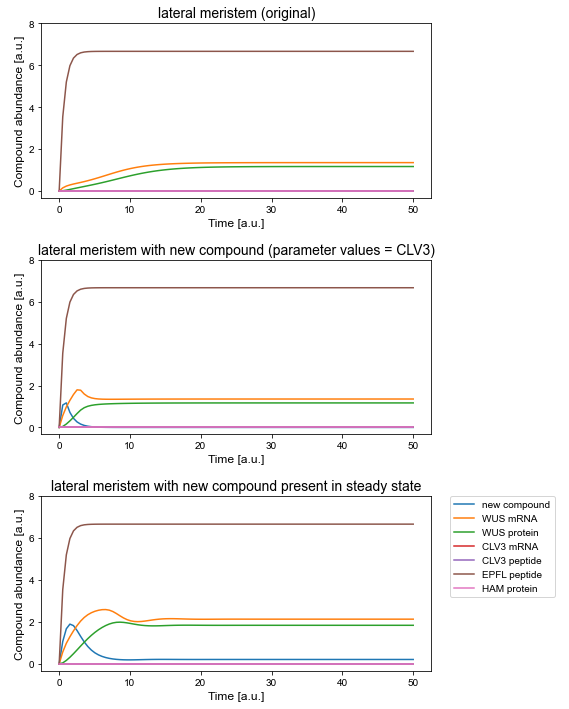

In [8]:
## Figures for altered parameter sets
handles = ["new compound", "WUS mRNA", "WUS protein", "CLV3 mRNA", "CLV3 peptide", "EPFL peptide", "HAM protein"]

fig, ax = plt.subplots(3,1, figsize = (8,10))

for i in range(len(param)):
    c = param[i] # take parameters for the i-th scenario
    m.update_parameters(c) # m is the result of plugging the values of the i-th scenario into previously defined modelling function
    s = Simulator(m) # start simulator with the model
    s.initialise(comp_t0[0]) 
    t_m,res_m = s.simulate(50)
    ax[i].plot(t_m,res_m)
    ax[i].set_xlabel('Time [a.u.]', fontsize = 12)
    ax[i].set_ylabel('Compound abundance [a.u.]', fontsize = 12)
    ax[i].set_ylim(top = 8)
    if ax[0]:
        ax[0].set_title('lateral meristem (original)', fontsize = 14)
    if ax[1]:
        ax[1].set_title('lateral meristem with new compound (parameter values = CLV3)', fontsize = 14)
    if ax[2]:
        ax[2].set_title('lateral meristem with new compound present in steady state', fontsize = 14)

plt.legend(handles, bbox_to_anchor=(1.05, 1), loc='best', borderaxespad=0.)
plt.tight_layout()
plt.style.use('seaborn-whitegrid')
# plt.savefig('new_compound_in_lateralcells_noHAM.pdf')
plt.show() # show plot